In [2]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

# TensorFlow imports
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

# Params

In [3]:
# Dataset information

# Test dataset is set explicitly, because the amount of data is very small
train_aug_image_folder = os.path.join('datasets', 'train_augmented_images')
train_image_folder = os.path.join('datasets', 'train_images')
test_image_folder = os.path.join('datasets', 'test_images')
img_height, img_width = 250, 250  # size of images
num_classes = 2  # me - not_me

# Training settings
validation_ratio = 0.15  # 15% for the validation
batch_size = 16

AUTOTUNE = tf.data.AUTOTUNE

# Dataset Creation

In [4]:
# Train set (non augmented)
train_ds = keras.preprocessing.image_dataset_from_directory(
    train_image_folder,
    validation_split=validation_ratio,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    label_mode='categorical',
    batch_size=batch_size,
    shuffle=True)

# Validation set (non augmented)
val_ds = keras.preprocessing.image_dataset_from_directory(
    train_image_folder,
    validation_split=validation_ratio,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True)

Found 180 files belonging to 2 classes.
Using 153 files for training.
Found 180 files belonging to 2 classes.
Using 27 files for validation.


In [5]:
# Train set (augmented)
train_aug_ds = keras.preprocessing.image_dataset_from_directory(
    train_aug_image_folder,
    validation_split=validation_ratio,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    label_mode='categorical',
    batch_size=batch_size,
    shuffle=True)

# Validation set (augmented)
val_aug_ds = keras.preprocessing.image_dataset_from_directory(
    train_aug_image_folder,
    validation_split=validation_ratio,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True)

Found 360 files belonging to 2 classes.
Using 306 files for training.
Found 360 files belonging to 2 classes.
Using 54 files for validation.


In [6]:
# Test set
test_ds = keras.preprocessing.image_dataset_from_directory(
    test_image_folder,
    image_size=(img_height, img_width),
    label_mode='categorical',
    shuffle=False)

Found 20 files belonging to 2 classes.


In [7]:
class_names = test_ds.class_names
class_names

['me', 'not_me']

# Models

VGG16

In [9]:
base_model = keras.applications.vgg16.VGG16(weights='imagenet',
                                            include_top=False,  # without dense part of the network
                                            input_shape=(img_height, img_width, 3))

# Set layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the convolutional layers of VGG16
flatten = keras.layers.Flatten()(base_model.output)
dense_4096_1 = keras.layers.Dense(4096, activation='relu')(flatten)
dense_4096_2 = keras.layers.Dense(4096, activation='relu')(dense_4096_1)
output = keras.layers.Dense(num_classes, activation='sigmoid')(dense_4096_2)

VGG16 = keras.models.Model(inputs=base_model.input,
                           outputs=output,
                           name='VGG16')
VGG16.summary()

58900480/58889256 [==============================] - 25s 0us/step
Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 250, 250, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 250, 250, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 125, 125, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 125, 125, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 125, 125, 128)     147584    
                                                             

ResNet50

In [10]:
base_model = keras.applications.ResNet50(weights='imagenet',
                                         include_top=False,  # without dense part of the network
                                         input_shape=(img_height, img_width, 3))

# Set layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of ResNet
global_avg_pooling = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(num_classes, activation='sigmoid')(global_avg_pooling)

ResNet50 = keras.models.Model(inputs=base_model.input,
                              outputs=output,
                              name='ResNet50')
ResNet50.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 256, 256, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 125, 125, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

MobileNet

In [18]:
base_model = keras.applications.MobileNet(weights='imagenet',
                                          include_top=False,  # without dense part of the network
                                          input_shape=(img_height, img_width, 3))

# Set layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of MobileNet
global_avg_pooling = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(num_classes, activation='sigmoid')(global_avg_pooling)

MobileNet = keras.models.Model(inputs=base_model.input,
                               outputs=output,
                               name='MobileNet')
MobileNet.summary()

Model: "MobileNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 125, 125, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 125, 125, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 125, 125, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 125, 125, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 125, 125, 32)     128       
 ation)                                                  

# Training

Possible Models:
- VGG16
- ResNet50
- MobileNet

In [44]:
face_classifier = MobileNet
face_classifier.summary()  # to check that model is choosen correctly

train_on_aug = True  # train on augmented dataset

if train_on_aug:
    train_ds = train_aug_ds
    val_ds = val_aug_ds

if train_on_aug:
    name_to_save = f"models/face_classifier_{face_classifier.name}_aug.h5"
else:
    name_to_save = f"models/face_classifier_{face_classifier.name}.h5"

Model: "MobileNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 125, 125, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 125, 125, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 125, 125, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 125, 125, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 125, 125, 32)     128       
 ation)                                                  

In [45]:
# ModelCheckpoint to save model in case of interrupting the learning process
checkpoint = ModelCheckpoint(name_to_save,
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose=1)

# EarlyStopping to find best model with a large number of epochs
earlystop = EarlyStopping(monitor='val_loss',
                          restore_best_weights=True,
                          patience=10,  # number of epochs with no improvement after which training will be stopped
                          verbose=1)

callbacks = [earlystop, checkpoint]

In [46]:
face_classifier.compile(loss='categorical_crossentropy',
                        optimizer=keras.optimizers.Adam(learning_rate=0.01),
                        metrics=['accuracy'])

In [47]:
epochs = 50

In [48]:
history = face_classifier.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds)

face_classifier.save(name_to_save)

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 0.2090 - accuracy: 0.9118
Epoch 00001: val_loss improved from inf to 0.15890, saving model to models\face_classifier_MobileNet_aug.h5
20/20 [==============================] - 3s 82ms/step - loss: 0.2090 - accuracy: 0.9118 - val_loss: 0.1589 - val_accuracy: 0.9259
Epoch 2/50
19/20 [===========================>..] - ETA: 0s - loss: 0.1276 - accuracy: 0.9539
Epoch 00002: val_loss improved from 0.15890 to 0.06052, saving model to models\face_classifier_MobileNet_aug.h5
20/20 [==============================] - 1s 43ms/step - loss: 0.1267 - accuracy: 0.9542 - val_loss: 0.0605 - val_accuracy: 0.9815
Epoch 3/50
19/20 [===========================>..] - ETA: 0s - loss: 0.0464 - accuracy: 0.9803
Epoch 00003: val_loss improved from 0.06052 to 0.01155, saving model to models\face_classifier_MobileNet_aug.h5
20/20 [==============================] - 1s 43ms/step - loss: 0.0461 - accuracy: 0.9804 - val_loss: 0.0116 - val_accuracy: 1.0

# Testing

In [17]:
model_name = 'face_classifier_MobileNet.h5'
face_classifier = keras.models.load_model(f'models/{model_name}')

In [9]:
def test_image_classifier_with_folder(model, path, y_true, img_height=250, img_width=250, class_names=['me', 'not_me']):
    '''
    Read all images from 'path' using tensorflow.keras.preprocessing.image module, 
    than classifies them using 'model' and compare result with 'y_true'.
    Calculate total accuracy based on 'path' test set.

    Parameters:
        model : Image classifier
        path (str): Path to the folder with images you want to test classifier on 
        y_true : True label of the images in the folder. Must be in 'class_names' list
        img_height (int): The height of the image that the classifier can process 
        img_width (int): The width of the image that the classifier can process
        class_names (array-like): List of class names 

    Returns:
        None
    '''
    num_classes = len(class_names)  # Number of classes
    total = 0  # number of images total
    correct = 0  # number of images classified correctly

    for filename in os.listdir(path):
        # read each image in the folder and classifies it
        test_path = os.path.join(path, filename)
        test_image = keras.preprocessing.image.load_img(
            test_path, target_size=(img_height, img_width, 3))
        # from image to array, can try type(test_image)
        test_image = keras.preprocessing.image.img_to_array(test_image)
        # shape from (250, 250, 3) to (1, 250, 250, 3)
        test_image = np.expand_dims(test_image, axis=0)
        result = model.predict(test_image)

        y_pred = class_names[np.array(result[0]).argmax(
            axis=0)]  # predicted class
        iscorrect = 'correct' if y_pred == y_true else 'incorrect'
        print('{} - {}'.format(iscorrect, filename))
        for index in range(num_classes):
            print("\t{:6} with probabily of {:.2f}%".format(
                class_names[index], result[0][index] * 100))

        total += 1
        if y_pred == y_true:
            correct += 1

    print("\nTotal accuracy is {:.2f}% = {}/{} samples classified correctly".format(
        correct/total*100, correct, total))

In [20]:
from sklearn.metrics import classification_report

path = os.path.join('datasets', 'test_images')
model = face_classifier

y_true = []
y_pred = []

directories = [os.path.join(path, class_names[0]), os.path.join(path, class_names[1])]

for idx, dir in enumerate(directories):
    for filename in os.listdir(dir):

        # read each image in the folder and classifies it
        test_path = os.path.join(dir, filename)
        test_image = keras.preprocessing.image.load_img(
            test_path, target_size=(img_height, img_width, 3))
        # from image to array, can try type(test_image)
        test_image = keras.preprocessing.image.img_to_array(test_image)
        # shape from (250, 250, 3) to (1, 250, 250, 3)
        test_image = np.expand_dims(test_image, axis=0)
        result = model.predict(test_image)

        true_class = idx
        pred_class = np.array(result[0]).argmax(axis=0)

        y_true.append(true_class)
        y_pred.append(pred_class)

print(classification_report(y_true, y_pred, target_names=class_names))


              precision    recall  f1-score   support

          me       0.67      0.80      0.73         5
      not_me       0.93      0.87      0.90        15

    accuracy                           0.85        20
   macro avg       0.80      0.83      0.81        20
weighted avg       0.86      0.85      0.85        20



In [60]:
test_image_classifier_with_folder(face_classifier,
                                  'datasets/test_images/me',
                                  y_true='me')

correct - me (1).jpg
	me     with probabily of 100.00%
	not_me with probabily of 0.00%
correct - me (2).jpg
	me     with probabily of 100.00%
	not_me with probabily of 0.00%
correct - me (3).jpg
	me     with probabily of 100.00%
	not_me with probabily of 0.00%
correct - me (4).jpg
	me     with probabily of 100.00%
	not_me with probabily of 0.00%
correct - me (5).jpg
	me     with probabily of 100.00%
	not_me with probabily of 0.00%

Total accuracy is 100.00% = 5/5 samples classified correctly


In [61]:
test_image_classifier_with_folder(face_classifier,
                                  'datasets/test_images/not_me',
                                  y_true='not_me')

incorrect - not_me (1).jpg
	me     with probabily of 100.00%
	not_me with probabily of 100.00%
correct - not_me (10).jpg
	me     with probabily of 0.00%
	not_me with probabily of 100.00%
correct - not_me (11).jpg
	me     with probabily of 0.00%
	not_me with probabily of 100.00%
correct - not_me (12).jpg
	me     with probabily of 0.00%
	not_me with probabily of 100.00%
correct - not_me (13).jpg
	me     with probabily of 0.00%
	not_me with probabily of 100.00%
correct - not_me (14).jpg
	me     with probabily of 0.00%
	not_me with probabily of 100.00%
correct - not_me (15).jpg
	me     with probabily of 0.00%
	not_me with probabily of 100.00%
correct - not_me (2).jpg
	me     with probabily of 0.00%
	not_me with probabily of 100.00%
correct - not_me (3).jpg
	me     with probabily of 0.00%
	not_me with probabily of 100.00%
correct - not_me (4).jpg
	me     with probabily of 0.00%
	not_me with probabily of 100.00%
correct - not_me (5).jpg
	me     with probabily of 0.00%
	not_me with probabily 

Test on specific image

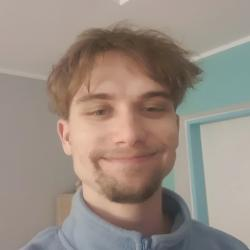

In [53]:
test_path = 'datasets/test_images/me/me (2).jpg'
test_image = keras.preprocessing.image.load_img(test_path, target_size=(img_height, img_width, 3))
test_image

In [54]:
test_image = keras.preprocessing.image.img_to_array(test_image)  # from image to array
# shape from (250, 250, 3) to (1, 250, 250, 3)
test_image = np.expand_dims(test_image, axis=0)
result = face_classifier.predict(test_image)

for index in range(num_classes):
    print("{:6} with probabily of {:.2f}%".format(
        class_names[index], result[0][index] * 100))

me     with probabily of 99.97%
not_me with probabily of 0.01%


# Plotting

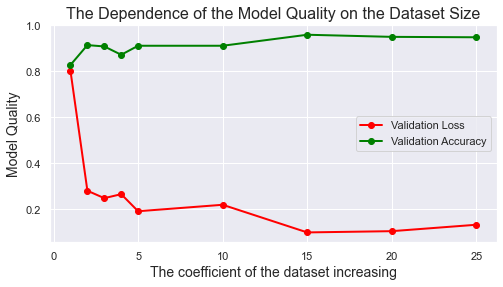

In [58]:
dataset_size = [1, 2, 3, 4, 5, 10, 15, 20, 25]
val_loss = [0.8011, 0.2802, 0.2479, 0.2653, 0.191, 0.2191, 0.09886, 0.10429, 0.1322]
val_accuracy = [0.8276, 0.9138, 0.908, 0.8718, 0.911, 0.911, 0.9589, 0.9497, 0.9479]


fig = plt.figure(figsize=(8, 4))
plt.plot(dataset_size, val_loss, c="red", linewidth=2, marker='o', label="Validation Loss")
plt.plot(dataset_size, val_accuracy, c="green", linewidth=2, marker='o', label="Validation Accuracy")

plt.title("The Dependence of the Model Quality on the Dataset Size", fontsize='16')
plt.xlabel("The coefficient of the dataset increasing", fontsize='14')
plt.ylabel("Model Quality", fontsize='14')
plt.legend(loc='best')
plt.savefig('testing/dataset_size_to_model_quality.jpg')